# 1. Prepare Data

In this Notebook I design the multivariate models (two different window types).

In [4]:
# Summaary data set

# Load data
import os
import pandas as pd
import glob
import json
import numpy as np
import seaborn as sns
import gc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import BallTree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tqdm
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# Confirm the current working directory
print("Current working directory:", os.getcwd())

2025-10-20 09:20:33.686208: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Current working directory: /home/qusta100/Gasoline


In [2]:
# Load data (restore from saved file)
final = pd.read_csv("/gpfs/scratch/qusta100/Gasoline/Data/Temp/final2.csv")

In [5]:
# Create Sample

# 1. Extract only unique stations with coordinates
stations_all = final[['station_uuid', 'latitude', 'longitude']].drop_duplicates()

# 2. Randomly select 500 seed stations and mark them
sample_stations = stations_all.sample(n=500, random_state=42)
sample_stations['is_seed'] = True

# 3. Add seed marker to all stations
stations = stations_all.merge(
    sample_stations[['station_uuid', 'is_seed']],
    on='station_uuid',
    how='left'
)
stations['is_seed'] = stations['is_seed'].fillna(False).astype(bool)
stations = stations.set_index('station_uuid')  # important: set index

# 4. Filter time series data
df_filtered = final.copy()

# 5. Statistics
print("Filtering completed:")
print(" - Seed stations:", stations['is_seed'].sum())
print(" - Total Stations:", df_filtered['station_uuid'].nunique())
print(" - Observations in dataset:", len(df_filtered))

/var/tmp/pbs.15531368.hpc-batch/ipykernel_89415/2628779682.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stations['is_seed'] = stations['is_seed'].fillna(False).astype(bool)


Filtering completed:
 - Seed stations: 500
 - Total Stations: 15093
 - Observations in dataset: 43320521


# 2. Window Size: 96

## 2.1. Estimate Model

In [6]:
# ==========================
# 1. Parameters
# ==========================
window_size      = 96      # 1 Tag in 15-Minuten-Intervallen
forecast_horizon = 8
radius_km        = 5
max_neighbors    = 5       # +1 für Target → 6 Stationen insgesamt

target_cols = [f'rank_e5_5km+{i}' for i in range(1, forecast_horizon+1)]
price_feats  = ['diesel', 'e5', 'e10']
time_feats   = ['time', 'holiday', 'Brent_Price']

# ==========================
# 2. Prepare global Data
# ==========================
df = df_filtered.copy()
df['date'] = pd.to_datetime(df['date'])
df[time_feats] = df[time_feats].apply(pd.to_numeric, errors='coerce')

if 'station_uuid' in stations.columns:
    stations = stations.set_index('station_uuid')

# Wochentags-Dummies einmal pro Datum
dates_wd = (
    df[['date','weekday']]
      .drop_duplicates('date')
      .set_index('date')['weekday']
)
wd_feats   = sorted(dates_wd.unique().tolist())
df_wd_base = pd.get_dummies(dates_wd).reindex(dates_wd.index, fill_value=0)

# 2a) Pivot nur die Preis-Features pro Station
df_price = (
    df.pivot_table(
        index='date',
        columns='station_uuid',
        values=price_feats,
        aggfunc='mean'
    )
    .sort_index()
)
# erhalte die tatsächlich vorhandenen Station-UUIDs
valid_sids = set(df_price.columns.get_level_values(1))

# 2b) Baue die Time-Features einmal pro Datum
df_time = (
    df[['date'] + time_feats]
      .drop_duplicates('date')
      .set_index('date')
      .reindex(df_price.index)
)

# BallTree für räumliche Nachbarsuche
coords_rad = np.radians(stations[['latitude','longitude']].values)
tree = BallTree(coords_rad, metric='haversine')

# ==========================
# 3. process_station
# ==========================
def process_station(station_id, coords):
    # Guard: Station selbst muss Price-Daten haben
    if station_id not in valid_sids:
        print(f"Skipping {station_id}: no price data")
        return [], []

    # 3a) Nachbarn suchen
    dist, ind = tree.query_radius(
        np.radians([[coords['latitude'], coords['longitude']]]),
        r=radius_km/6371, return_distance=True, sort_results=True
    )
    neigh = stations.iloc[ind[0]].index.tolist()
    if station_id in neigh:
        neigh.remove(station_id)
    # nur wirklich vorhandene Nachbarn
    neigh = [sid for sid in neigh if sid in valid_sids]

    # Target + echte Nachbarn
    neighbor_ids = [station_id] + neigh[:max_neighbors]
    # Dummy-Platzhalter
    needed   = (max_neighbors+1) - len(neighbor_ids)
    dummy_ids = [f"dummy_{i}" for i in range(needed)]
    all_ids  = neighbor_ids + dummy_ids

    T = len(df_price)

    # 3b) Preis-Array (T × #stations × #price_feats)
    price_dfs = []
    for sid in all_ids:
        if sid in valid_sids:
            df_sid = df_price.xs(sid, axis=1, level=1).reindex(columns=price_feats)
        else:
            df_sid = pd.DataFrame(
                np.nan, index=df_price.index, columns=price_feats
            )
        price_dfs.append(df_sid)

    df_p = pd.concat(price_dfs, axis=1)
    arr_price = df_p.values.reshape(T, max_neighbors+1, len(price_feats))

    # 3c) Zeit-Array (T × (#time_feats + #wd_feats))
    arr_time = np.concatenate([
        df_time.values,
        df_wd_base.reindex(df_time.index).values
    ], axis=1)

    # 3d) Zielwerte
    df_t = (
        df[df['station_uuid'] == station_id]
          .set_index('date')
          .sort_index()
          .reindex(df_price.index)
    )[target_cols]

    # 3e) Fenster erzeugen
    X_list, y_list = [], []
    for i in range(T - window_size - forecast_horizon + 1):
        w_price = arr_price[i : i+window_size]
        w_time  = arr_time[i : i+window_size]
        seq = np.concatenate([
            w_price.reshape(window_size, -1),
            w_time
        ], axis=1)
        X_list.append(seq)

        yw = df_t.iloc[i+window_size : i+window_size+forecast_horizon].values
        #y_list.append(yw[np.arange(forecast_horizon), np.arange(forecast_horizon)])
        y_list.append(yw[:, 0])

    return X_list, y_list

# ==========================
# 4. parallel
# ==========================
def parallel_feature_engineering(seed_stations, batch_size=20, n_jobs=1):
    X_all, y_all = [], []
    for start in range(0, len(seed_stations), batch_size):
        batch = seed_stations.iloc[start:start+batch_size]
        res = Parallel(n_jobs=n_jobs)(
            delayed(process_station)(sid, coords)
            for sid, coords in batch.iterrows()
        )
        for Xp, yp in res:
            X_all.extend(Xp)
            y_all.extend(yp)
    return np.array(X_all), np.array(y_all)

# ==========================
# 5. run
# ==========================
seed = stations[stations['is_seed']]
X_final, y_final = parallel_feature_engineering(seed, batch_size=20, n_jobs=1)

if X_final.ndim == 3 and y_final.ndim == 2:
    maskX = np.isnan(X_final).mean((1,2)) < 0.2
    maskY = np.isnan(y_final).mean(1) == 0
    idx   = np.where(maskX & maskY)[0]
    X_clean, y_clean = X_final[idx], y_final[idx]
    print(f"Clean windows: {X_clean.shape}, {y_clean.shape}")
else:
    print("No valid windows.")


Skipping 1ed484e2-31c4-4d20-a465-caf0517b89e8: no price data
Skipping 51d4b48d-a095-1aa0-e100-80009459e03a: no price data
Skipping 51d4b52d-a095-1aa0-e100-80009459e03a: no price data
Skipping 51d4b647-a095-1aa0-e100-80009459e03a: no price data
Skipping 51d4b695-a095-1aa0-e100-80009459e03a: no price data
Skipping 52fb0db0-ceb5-1550-e100-80009459e02b: no price data
Skipping 772e8e53-b726-4b20-8878-347e085ab2f0: no price data
Skipping 7e89c71c-fa17-472d-9ec3-aef15bceccf1: no price data
Skipping 82f45906-2adb-49fd-b3e5-032c23609c77: no price data
Skipping b0d8aa54-047d-40ee-99ee-9542bcfaba63: no price data
Skipping c8f8fef5-02ce-4499-a68a-113000d6fad5: no price data
Skipping cd8ba6a6-8316-1ed5-a3ae-d31280b2585f: no price data
Clean windows: (730006, 96, 28), (730006, 8)


In [10]:
# Previous check for NaNs in the cleaned arrays
print("Total NaNs in X_clean:", np.isnan(X_clean).sum(), "out of", X_clean.size)
print("Total NaNs in y_clean:", np.isnan(y_clean).sum(), "out of", y_clean.size)

Total NaNs in X_clean: 139094297 out of 1962256128
Total NaNs in y_clean: 0 out of 5840048


In [11]:
# Save features/targets
np.save("/gpfs/scratch/qusta100/Gasoline/Data/Temp/X_clean_96_multi.npy", X_clean)
np.save("/gpfs/scratch/qusta100/Gasoline/Data/Temp/y_clean_96_multi.npy", y_clean)

In [42]:
# Load features/targets
X_clean = np.load("/gpfs/scratch/qusta100/Gasoline/Data/Temp/X_clean_96_multi.npy")
y_clean = np.load("/gpfs/scratch/qusta100/Gasoline/Data/Temp/y_clean_96_multi.npy")

In [43]:
# Split in Training und Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

# Hyperparameter as in the paper
conv_filters = 64      # statt 512
kernel_size = 3
lstm_units = 64        # statt 512
pool_sizes = [(3,), (2,)]
dense_units = [128, 64, 32]   # statt 512,256,128,64,32

learning_rate = 3e-4

# Example: X_train.shape = (n_samples, 96, 6, 3)  # 6 Stations, 3 feature per Station
if len(X_train.shape) == 4:
    # Kombiniere Stationen und Features zu einer Feature-Dimension:
    X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2] * X_train.shape[3])
    X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2] * X_test.shape[3])
else:
    X_train_reshaped = X_train
    X_test_reshaped = X_test
    
X_train_reshaped = np.nan_to_num(X_train_reshaped, nan=0.0, posinf=0.0, neginf=0.0)
X_test_reshaped = np.nan_to_num(X_test_reshaped, nan=0.0, posinf=0.0, neginf=0.0)

print("X_train_reshaped.shape:", X_train_reshaped.shape)

input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])  # (timesteps, features)
output_dim = y_train.shape[1]  # Multi-Step Output (z. B. 10 Tage)

inputs = Input(shape=input_shape)

# 1. CNN-Block
x = layers.Conv1D(conv_filters, kernel_size, padding='same', activation='relu')(inputs)
x = layers.MaxPooling1D(pool_size=pool_sizes[0][0])(x)
x = layers.Conv1D(conv_filters, kernel_size, padding='same', activation='relu')(x)
x = layers.MaxPooling1D(pool_size=pool_sizes[1][0])(x)
cnn_out = layers.Flatten()(x)  # flach für dense layers

# 2. LSTM-Block
lstm_x = layers.LSTM(lstm_units, return_sequences=True)(inputs)
lstm_x = layers.LSTM(lstm_units, return_sequences=False)(lstm_x)
# lstm_x ist schon flach

# 3. Skip-Connection (Concatenate CNN- und LSTM-Block)
concat = layers.Concatenate()([cnn_out, lstm_x])

# 4. Dense Layers with LeakyReLU
d = concat
for units in dense_units:
    d = layers.Dense(units)(d)
    d = layers.LeakyReLU()(d)

# 5. Output-Layer (Linear)
outputs = layers.Dense(output_dim)(d)

model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mse',
    metrics=['mae']
)

model.summary()

# Training
history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=10,       # Passe an!
    batch_size=128,
    verbose=1
)

loss, mae = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", loss)
print("Test MAE:", mae)


X_train_reshaped.shape: (466805, 96, 28)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 96, 64)    │      5,440 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 32, 64)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 32, 64)    │     12,352 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 16, 64)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 96, 64)    │     23,808 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1024)      │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     33,024 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1088)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    139,392 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128)       │          0 │ dense[0][0]       │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 64)        │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32)        │          0 │ dense_2[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8)         │        264 │ leaky_re_lu_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 224,616 (877.41 KB)

 Trainable params: 224,616 (877.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
 136/3647 ━━━━━━━━━━━━━━━━━━━━ 4:30 77ms/step - loss: 38.6312 - mae: 4.4849

KeyboardInterrupt: 

In [2]:
# Predict model
y_pred = model.predict(X_test)

# Save model and test data
model.save("/gpfs/scratch/qusta100/Gasoline/Data/Temp/my_model_96_multi.keras")

np.save('/gpfs/scratch/qusta100/Gasoline/Data/Temp/X_test_96_multi.npy', X_test)
np.save('/gpfs/scratch/qusta100/Gasoline/Data/Temp/y_test_96_multi.npy', y_test)
np.save('/gpfs/scratch/qusta100/Gasoline/Data/Temp/X_train_reshaped_96_multi.npy', X_train_reshaped)
np.save('/gpfs/scratch/qusta100/Gasoline/Data/Temp/X_test_reshaped_96_multi.npy', X_test_reshaped)
np.save('/gpfs/scratch/qusta100/Gasoline/Data/Temp/y_pred_96_multi.npy', y_pred)# Predict model
y_pred = model.predict(X_test_reshaped)

NameError: name 'model' is not defined

# 2.2. Graph Production

In [58]:
# Load model and data

# load test data
X_test = np.load('/gpfs/scratch/qusta100/Gasoline/Data/Temp/X_test_96_multi.npy')
y_test = np.load('/gpfs/scratch/qusta100/Gasoline/Data/Temp/y_test_96_multi.npy')
X_train_reshaped = np.load('/gpfs/scratch/qusta100/Gasoline/Data/Temp/X_train_reshaped_96_multi.npy')
X_test_reshaped = np.load('/gpfs/scratch/qusta100/Gasoline/Data/Temp/X_test_reshaped_96_multi.npy')
y_pred = np.load('/gpfs/scratch/qusta100/Gasoline/Data/Temp/y_pred_96_multi.npy')

y_final_clean = np.load("/gpfs/scratch/qusta100/Gasoline/Data/Temp/y_clean_96_multi.npy")

In [6]:
# Check for zeros (NAs are replaced by 0 in the previous step)

print("NaN in X_train:", np.isnan(X_train_reshaped).sum())
print("Inf in X_train:", np.isinf(X_train_reshaped).sum())

NaN in X_train: 0
Inf in X_train: 0


MAE for step 1 (t+15min): 2.52
MAE for step 2 (t+30min): 2.51
MAE for step 3 (t+45min): 2.51
MAE for step 4 (t+60min): 2.50
MAE for step 5 (t+75min): 2.50
MAE for step 6 (t+90min): 2.50
MAE for step 7 (t+105min): 2.51
MAE for step 8 (t+120min): 2.53


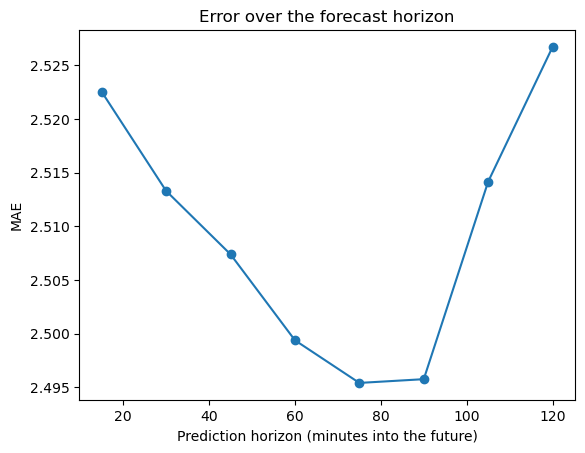

In [7]:
# Check whether the model error increases over the forecast horizon

# Calculate MAE for each prediction step (1 to 8)
mae_per_step = []
for step in range(y_test.shape[1]):   # 0...7, for 8 forecast steps
    mae = mean_absolute_error(y_test[:, step], y_pred[:, step])
    mae_per_step.append(mae)
    print(f"MAE for step {step+1} (t+{(step+1)*15}min): {mae:.2f}")

plt.plot(np.arange(1, 9)*15, mae_per_step, marker='o')
plt.xlabel("Prediction horizon (minutes into the future)")
plt.ylabel("MAE")
plt.title("Error over the forecast horizon")
plt.savefig("graphs/96_multi_mae_over_horizon.png")  # statt plt.show()

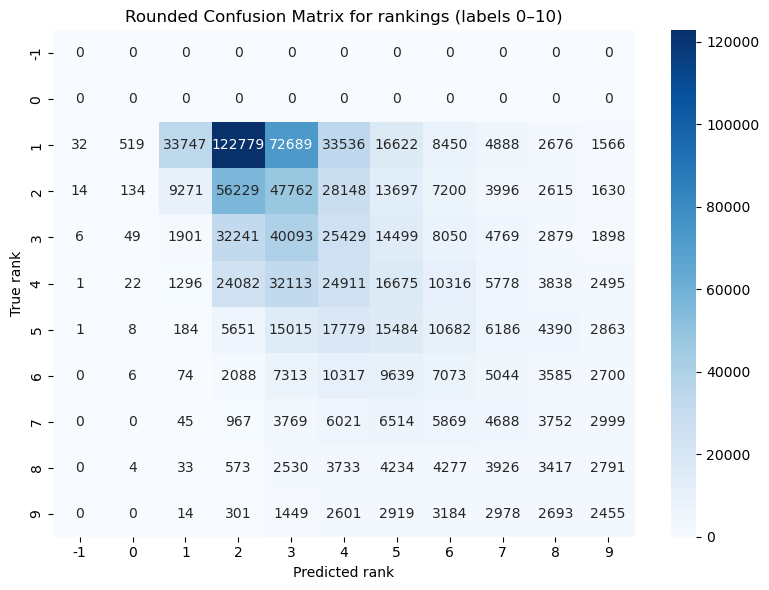

In [47]:
# 1) Round and clamp values to [0, 10]
true_rounded = np.round(y_test.flatten()).astype(int)
pred_rounded = np.round(y_pred.flatten()).astype(int)

# 2) Explicitly define labels 0–10
labels = list(range(min(pred_rounded), 10))

# 3) Compute confusion matrix for these classes only
cm = confusion_matrix(true_rounded, pred_rounded, labels=labels)

# 4) Plot with correct tick labels
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted rank")
plt.ylabel("True rank")
plt.title("Rounded Confusion Matrix for rankings (labels 0–10)")
plt.tight_layout()
plt.savefig("graphs/96_multi_confusion_matrix.png") 
plt.show()

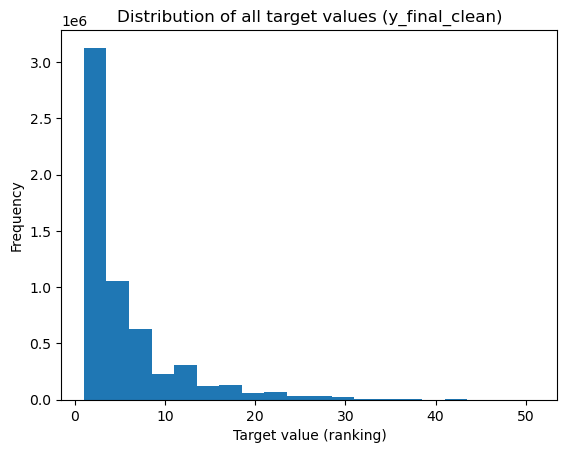

In [9]:
# Plot a histogram of all target values (flattened) to visualize their distribution
plt.hist(y_final_clean.flatten(), bins=20)
plt.title("Distribution of all target values (y_final_clean)")
plt.xlabel("Target value (ranking)")
plt.ylabel("Frequency")
plt.savefig("graphs/96_multi_hist_y_final_clean.png") 
plt.show()

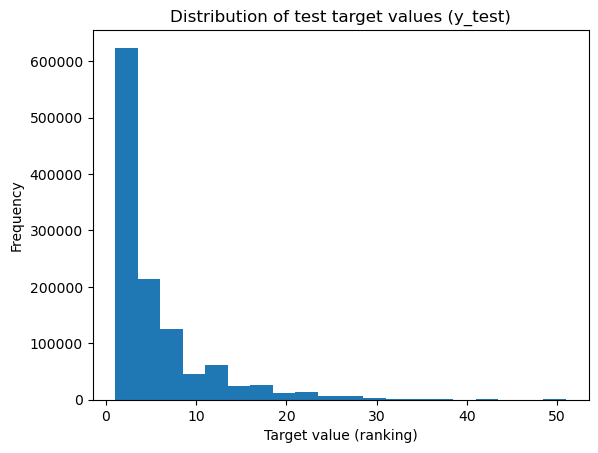

In [10]:
# Plot a histogram of the test target values to visualize their distribution
plt.clf()  # clear figure
plt.hist(y_test.flatten(), bins=20)
plt.title("Distribution of test target values (y_test)")
plt.xlabel("Target value (ranking)")
plt.ylabel("Frequency")
plt.savefig("graphs/96_multi_hist_y_test_clean.png")
plt.show()

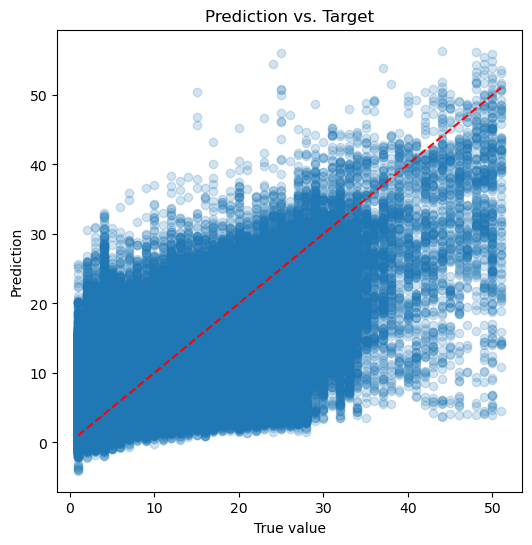

In [11]:
# Scatter plot: true values vs. predicted values to visualize prediction quality
plt.figure(figsize=(6,6))
plt.scatter(y_test.flatten(), y_pred.flatten(), alpha=0.2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal diagonal line
plt.xlabel("True value")
plt.ylabel("Prediction")
plt.title("Prediction vs. Target")
plt.savefig("graphs/96_multi_scatter_plot.png") 
plt.show()

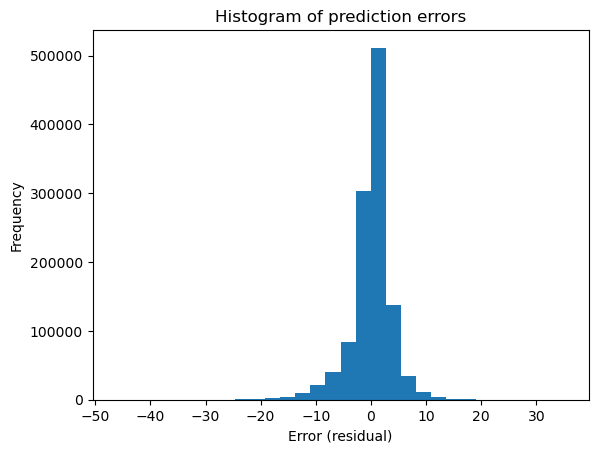

In [12]:
# Calculate and plot the histogram of prediction errors (residuals)
errors = y_pred.flatten() - y_test.flatten()
plt.hist(errors, bins=30)
plt.xlabel("Error (residual)")
plt.ylabel("Frequency")
plt.title("Histogram of prediction errors")
plt.savefig("graphs/96_multi_prediction_errors.png") 
plt.show()

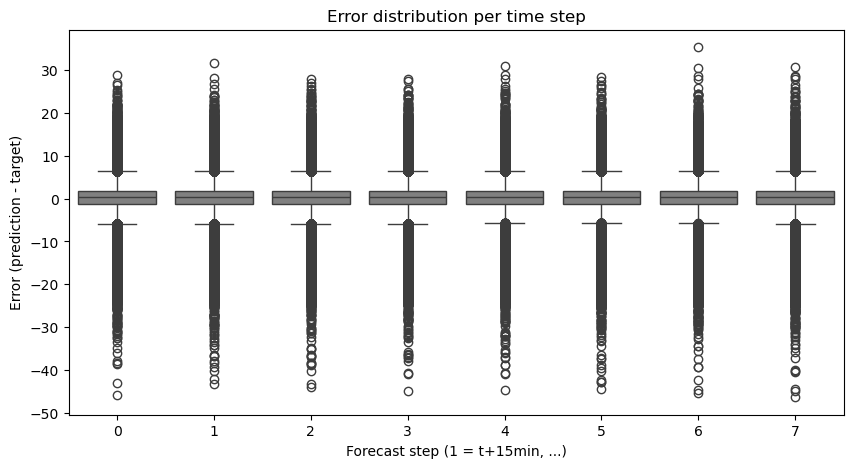

In [13]:
# Plot the error (prediction minus target) distribution for each forecast step using boxplots
errors_per_step = y_pred - y_test

# Plot
plt.figure(figsize=(10, 5))
sns.boxplot(data=errors_per_step, color='gray')  # <-- einheitliche Farbe hier
plt.xlabel("Forecast step (1 = t+15min, ...)")
plt.ylabel("Error (prediction - target)")
plt.title("Error distribution per time step")
plt.savefig("graphs/96_multi_error_per_timestep.png")
plt.show()

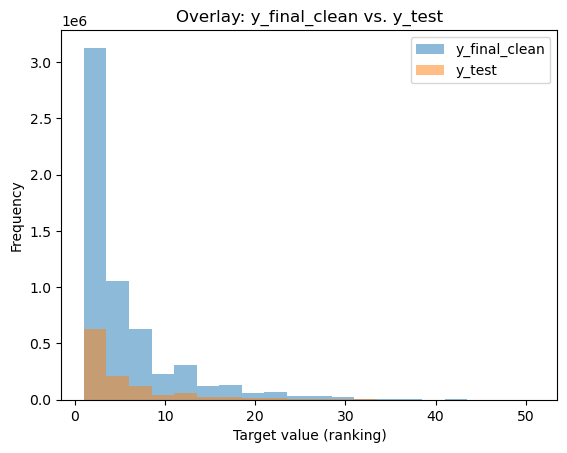

In [14]:
# Test for overlay between y_final_clean and y_test

plt.hist(y_final_clean.flatten(), bins=20, alpha=0.5, label='y_final_clean')
plt.hist(y_test.flatten(), bins=20, alpha=0.5, label='y_test')
plt.title("Overlay: y_final_clean vs. y_test")
plt.xlabel("Target value (ranking)")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("graphs/96_multi_overlay.png")
plt.show()

In [15]:
# Minimum and maximum values in y_test (true targets)
print("Min/Max y_test:", np.nanmin(y_test), np.nanmax(y_test))

# Minimum and maximum values in y_pred (model predictions)
print("Min/Max y_pred:", np.nanmin(y_pred), np.nanmax(y_pred))

# Unique integer values in the rounded true targets
print("Unique rounded values in y_test:", np.unique(true_rounded))

# Unique integer values in the rounded predictions
print("Unique rounded values in y_pred:", np.unique(pred_rounded))

# Number of NaN values in y_test
print("Number of NaN in y_test:", np.isnan(y_test).sum())

# Number of NaN values in y_pred
print("Number of NaN in y_pred:", np.isnan(y_pred).sum())#

Min/Max y_test: 1.0 51.0
Min/Max y_pred: -4.0759044 56.359917
Unique rounded values in y_test: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51]
Unique rounded values in y_pred: [-4 -3 -2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43
 44 45 46 47 48 49 50 51 52 53 54 55 56]
Number of NaN in y_test: 0
Number of NaN in y_pred: 0


In [59]:
# Create Table for Latex
# Example: y_test and y_pred are numpy arrays of shape (n_samples, 8)
# y_test = ...
# y_pred = ...

latex_rows = []

for step in range(y_test.shape[1]):  # 0...7
    y_true = y_test[:, step]
    y_pred_step = y_pred[:, step]

    mae = mean_absolute_error(y_true, y_pred_step)
    mse = mean_squared_error(y_true, y_pred_step)
    rmse = np.sqrt(mse)  # manually calculated

    time_step = f"t + {(step + 1) * 15}\,min"
    latex_row = f"{time_step} & {mae:.3f} & {rmse:.3f}  \\\\"
    latex_rows.append(latex_row)

# Assemble LaTeX table with evenly distributed column widths
latex_table = r"""\begin{table}[ht]
\centering
\caption{Evaluation Metrics per Forecast Horizon}
\label{tab:evaluation_metrics}
\begin{tabularx}{\textwidth}{X X X X X}
\toprule
\textbf{Time Step} & \textbf{MAE} & \textbf{RMSE} \\
\midrule
""" + "\n".join(latex_rows) + r"""
\bottomrule
\end{tabularx}
\end{table}
"""

print(latex_table)

\begin{table}[ht]
\centering
\caption{Evaluation Metrics per Forecast Horizon}
\label{tab:evaluation_metrics}
\begin{tabularx}{\textwidth}{X X X X X}
\toprule
\textbf{Time Step} & \textbf{MAE} & \textbf{RMSE} \\
\midrule
t + 15\,min & 2.523 & 3.814  \\
t + 30\,min & 2.513 & 3.792  \\
t + 45\,min & 2.507 & 3.780  \\
t + 60\,min & 2.499 & 3.763  \\
t + 75\,min & 2.495 & 3.771  \\
t + 90\,min & 2.496 & 3.776  \\
t + 105\,min & 2.514 & 3.809  \\
t + 120\,min & 2.527 & 3.833  \\
\bottomrule
\end{tabularx}
\end{table}



# 3. Window Size: 48

## 3.1. Estimate Model

In [12]:
# ==========================
# 1. Parameters
# ==========================
window_size      = 48      # 1 Tag in 15-Minuten-Intervallen
forecast_horizon = 8
radius_km        = 5
max_neighbors    = 5       # +1 für Target → 6 Stationen insgesamt

target_cols = [f'rank_e5_5km+{i}' for i in range(1, forecast_horizon+1)]
price_feats  = ['diesel', 'e5', 'e10']
time_feats   = ['time', 'holiday', 'Brent_Price']

# ==========================
# 2. Prepare global Data
# ==========================
df = df_filtered.copy()
df['date'] = pd.to_datetime(df['date'])
df[time_feats] = df[time_feats].apply(pd.to_numeric, errors='coerce')

if 'station_uuid' in stations.columns:
    stations = stations.set_index('station_uuid')

# Wochentags-Dummies einmal pro Datum
dates_wd = (
    df[['date','weekday']]
      .drop_duplicates('date')
      .set_index('date')['weekday']
)
wd_feats   = sorted(dates_wd.unique().tolist())
df_wd_base = pd.get_dummies(dates_wd).reindex(dates_wd.index, fill_value=0)

# 2a) Pivot nur die Preis-Features pro Station
df_price = (
    df.pivot_table(
        index='date',
        columns='station_uuid',
        values=price_feats,
        aggfunc='mean'
    )
    .sort_index()
)
# erhalte die tatsächlich vorhandenen Station-UUIDs
valid_sids = set(df_price.columns.get_level_values(1))

# 2b) Baue die Time-Features einmal pro Datum
df_time = (
    df[['date'] + time_feats]
      .drop_duplicates('date')
      .set_index('date')
      .reindex(df_price.index)
)

# BallTree für räumliche Nachbarsuche
coords_rad = np.radians(stations[['latitude','longitude']].values)
tree = BallTree(coords_rad, metric='haversine')

# ==========================
# 3. process_station
# ==========================
def process_station(station_id, coords):
    # Guard: Station selbst muss Price-Daten haben
    if station_id not in valid_sids:
        print(f"Skipping {station_id}: no price data")
        return [], []

    # 3a) Nachbarn suchen
    dist, ind = tree.query_radius(
        np.radians([[coords['latitude'], coords['longitude']]]),
        r=radius_km/6371, return_distance=True, sort_results=True
    )
    neigh = stations.iloc[ind[0]].index.tolist()
    if station_id in neigh:
        neigh.remove(station_id)
    # nur wirklich vorhandene Nachbarn
    neigh = [sid for sid in neigh if sid in valid_sids]

    # Target + echte Nachbarn
    neighbor_ids = [station_id] + neigh[:max_neighbors]
    # Dummy-Platzhalter
    needed   = (max_neighbors+1) - len(neighbor_ids)
    dummy_ids = [f"dummy_{i}" for i in range(needed)]
    all_ids  = neighbor_ids + dummy_ids

    T = len(df_price)

    # 3b) Preis-Array (T × #stations × #price_feats)
    price_dfs = []
    for sid in all_ids:
        if sid in valid_sids:
            df_sid = df_price.xs(sid, axis=1, level=1).reindex(columns=price_feats)
        else:
            df_sid = pd.DataFrame(
                np.nan, index=df_price.index, columns=price_feats
            )
        price_dfs.append(df_sid)

    df_p = pd.concat(price_dfs, axis=1)
    arr_price = df_p.values.reshape(T, max_neighbors+1, len(price_feats))

    # 3c) Zeit-Array (T × (#time_feats + #wd_feats))
    arr_time = np.concatenate([
        df_time.values,
        df_wd_base.reindex(df_time.index).values
    ], axis=1)

    # 3d) Zielwerte
    df_t = (
        df[df['station_uuid'] == station_id]
          .set_index('date')
          .sort_index()
          .reindex(df_price.index)
    )[target_cols]

    # 3e) Fenster erzeugen
    X_list, y_list = [], []
    for i in range(T - window_size - forecast_horizon + 1):
        w_price = arr_price[i : i+window_size]
        w_time  = arr_time[i : i+window_size]
        seq = np.concatenate([
            w_price.reshape(window_size, -1),
            w_time
        ], axis=1)
        X_list.append(seq)

        yw = df_t.iloc[i+window_size : i+window_size+forecast_horizon].values
        #y_list.append(yw[np.arange(forecast_horizon), np.arange(forecast_horizon)])
        y_list.append(yw[:, 0])

    return X_list, y_list

# ==========================
# 4. parallel
# ==========================
def parallel_feature_engineering(seed_stations, batch_size=20, n_jobs=1):
    X_all, y_all = [], []
    for start in range(0, len(seed_stations), batch_size):
        batch = seed_stations.iloc[start:start+batch_size]
        res = Parallel(n_jobs=n_jobs)(
            delayed(process_station)(sid, coords)
            for sid, coords in batch.iterrows()
        )
        for Xp, yp in res:
            X_all.extend(Xp)
            y_all.extend(yp)
    return np.array(X_all), np.array(y_all)

# ==========================
# 5. run
# ==========================
seed = stations[stations['is_seed']]
X_final, y_final = parallel_feature_engineering(seed, batch_size=20, n_jobs=1)

if X_final.ndim == 3 and y_final.ndim == 2:
    maskX = np.isnan(X_final).mean((1,2)) < 0.2
    maskY = np.isnan(y_final).mean(1) == 0
    idx   = np.where(maskX & maskY)[0]
    X_clean, y_clean = X_final[idx], y_final[idx]
    print(f"Clean windows: {X_clean.shape}, {y_clean.shape}")
else:
    print("No valid windows.")

Skipping 1ed484e2-31c4-4d20-a465-caf0517b89e8: no price data
Skipping 51d4b48d-a095-1aa0-e100-80009459e03a: no price data
Skipping 51d4b52d-a095-1aa0-e100-80009459e03a: no price data
Skipping 51d4b647-a095-1aa0-e100-80009459e03a: no price data
Skipping 51d4b695-a095-1aa0-e100-80009459e03a: no price data
Skipping 52fb0db0-ceb5-1550-e100-80009459e02b: no price data
Skipping 772e8e53-b726-4b20-8878-347e085ab2f0: no price data
Skipping 7e89c71c-fa17-472d-9ec3-aef15bceccf1: no price data
Skipping 82f45906-2adb-49fd-b3e5-032c23609c77: no price data
Skipping b0d8aa54-047d-40ee-99ee-9542bcfaba63: no price data
Skipping c8f8fef5-02ce-4499-a68a-113000d6fad5: no price data
Skipping cd8ba6a6-8316-1ed5-a3ae-d31280b2585f: no price data
Clean windows: (721220, 48, 28), (721220, 8)


In [13]:
# Previous check for NaNs in the cleaned arrays
print("Total NaNs in X_clean:", np.isnan(X_clean).sum(), "out of", X_clean.size)
print("Total NaNs in y_clean:", np.isnan(y_clean).sum(), "out of", y_clean.size)

Total NaNs in X_clean: 66883988 out of 969319680
Total NaNs in y_clean: 0 out of 5769760


In [14]:
# Save features/targets
np.save("/gpfs/scratch/qusta100/Gasoline/Data/Temp/X_clean_48_multi.npy", X_clean)
np.save("/gpfs/scratch/qusta100/Gasoline/Data/Temp/y_clean_48_multi.npy", y_clean)

In [33]:
# Load features/targets
X_final_clean = np.load("/gpfs/scratch/qusta100/Gasoline/Data/Temp/X_clean_48_multi.npy")
y_final_clean = np.load("/gpfs/scratch/qusta100/Gasoline/Data/Temp/y_clean_48_multi.npy")

In [ ]:
# Split in Training und Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

# Hyperparameter as in the paper
conv_filters = 64      # statt 512
kernel_size = 3
lstm_units = 64        # statt 512
pool_sizes = [(3,), (2,)]
dense_units = [128, 64, 32]   # statt 512,256,128,64,32

learning_rate = 3e-4

# Example: X_train.shape = (n_samples, 96, 6, 3)  # 6 Stations, 3 feature per Station
if len(X_train.shape) == 4:
    # Kombiniere Stationen und Features zu einer Feature-Dimension:
    X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2] * X_train.shape[3])
    X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2] * X_test.shape[3])
else:
    X_train_reshaped = X_train
    X_test_reshaped = X_test
    
X_train_reshaped = np.nan_to_num(X_train_reshaped, nan=0.0, posinf=0.0, neginf=0.0)
X_test_reshaped = np.nan_to_num(X_test_reshaped, nan=0.0, posinf=0.0, neginf=0.0)

print("X_train_reshaped.shape:", X_train_reshaped.shape)

input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])  # (timesteps, features)
output_dim = y_train.shape[1]  # Multi-Step Output (z. B. 10 Tage)

inputs = Input(shape=input_shape)

# 1. CNN-Block
x = layers.Conv1D(conv_filters, kernel_size, padding='same', activation='relu')(inputs)
x = layers.MaxPooling1D(pool_size=pool_sizes[0][0])(x)
x = layers.Conv1D(conv_filters, kernel_size, padding='same', activation='relu')(x)
x = layers.MaxPooling1D(pool_size=pool_sizes[1][0])(x)
cnn_out = layers.Flatten()(x)  # flach für dense layers

# 2. LSTM-Block
lstm_x = layers.LSTM(lstm_units, return_sequences=True)(inputs)
lstm_x = layers.LSTM(lstm_units, return_sequences=False)(lstm_x)
# lstm_x ist schon flach

# 3. Skip-Connection (Concatenate CNN- und LSTM-Block)
concat = layers.Concatenate()([cnn_out, lstm_x])

# 4. Dense Layers with LeakyReLU
d = concat
for units in dense_units:
    d = layers.Dense(units)(d)
    d = layers.LeakyReLU()(d)

# 5. Output-Layer (Linear)
outputs = layers.Dense(output_dim)(d)

model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mse',
    metrics=['mae']
)

model.summary()

# Training
history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=10,       # Passe an!
    batch_size=128,
    verbose=1
)

loss, mae = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", loss)
print("Test MAE:", mae)

In [ ]:
# Predict model
y_pred = model.predict(X_test_reshaped)

# Save model and test data
model.save("/gpfs/scratch/qusta100/Gasoline/Data/Temp/48_multi/my_model_48_multi.keras")

np.save('/gpfs/scratch/qusta100/Gasoline/Data/Temp/48_multi/X_test_48_multi.npy', X_test)
np.save('/gpfs/scratch/qusta100/Gasoline/Data/Temp/48_multi/y_test_48_multi.npy', y_test)
np.save('/gpfs/scratch/qusta100/Gasoline/Data/Temp/48_multi/X_train_reshaped_48_multi.npy', X_train_reshaped)
np.save('/gpfs/scratch/qusta100/Gasoline/Data/Temp/48_multi/X_test_reshaped_48_multi.npy', X_test_reshaped)
np.save('/gpfs/scratch/qusta100/Gasoline/Data/Temp/48_multi/y_pred_48_multi.npy', y_pred)

## 3.2. Graph Production

In [56]:
# Load model and data

# load test data
X_test = np.load('/gpfs/scratch/qusta100/Gasoline/Data/Temp/X_test_48_multi.npy')
y_test = np.load('/gpfs/scratch/qusta100/Gasoline/Data/Temp/y_test_48_multi.npy')
X_train_reshaped = np.load('/gpfs/scratch/qusta100/Gasoline/Data/Temp/X_train_reshaped_48_multi.npy')
X_test_reshaped = np.load('/gpfs/scratch/qusta100/Gasoline/Data/Temp/X_test_reshaped_48_multi.npy')
y_pred = np.load('/gpfs/scratch/qusta100/Gasoline/Data/Temp/y_pred_48_multi.npy')

y_final_clean = np.load("/gpfs/scratch/qusta100/Gasoline/Data/Temp/y_clean_48_multi.npy")

In [20]:
# Check for zeros (NAs are replaced by 0 in the previous step)

print("NaN in X_train:", np.isnan(X_train_reshaped).sum())
print("Inf in X_train:", np.isinf(X_train_reshaped).sum())

NaN in X_train: 0
Inf in X_train: 0


MAE for step 1 (t+15min): 2.32
MAE for step 2 (t+30min): 2.30
MAE for step 3 (t+45min): 2.31
MAE for step 4 (t+60min): 2.30
MAE for step 5 (t+75min): 2.31
MAE for step 6 (t+90min): 2.31
MAE for step 7 (t+105min): 2.32
MAE for step 8 (t+120min): 2.33


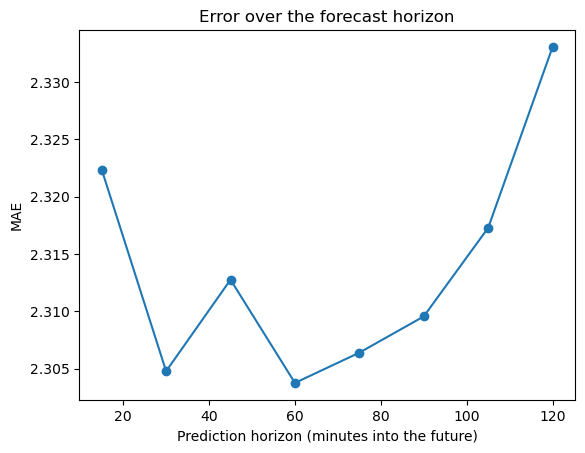

In [21]:
# Check whether the model error increases over the forecast horizon

# Calculate MAE for each prediction step (1 to 8)
mae_per_step = []
for step in range(y_test.shape[1]):   # 0...7, for 8 forecast steps
    mae = mean_absolute_error(y_test[:, step], y_pred[:, step])
    mae_per_step.append(mae)
    print(f"MAE for step {step+1} (t+{(step+1)*15}min): {mae:.2f}")

plt.plot(np.arange(1, 9)*15, mae_per_step, marker='o')
plt.xlabel("Prediction horizon (minutes into the future)")
plt.ylabel("MAE")
plt.title("Error over the forecast horizon")
plt.savefig("graphs/48_multi_mae_over_horizon.png")  # statt plt.show()

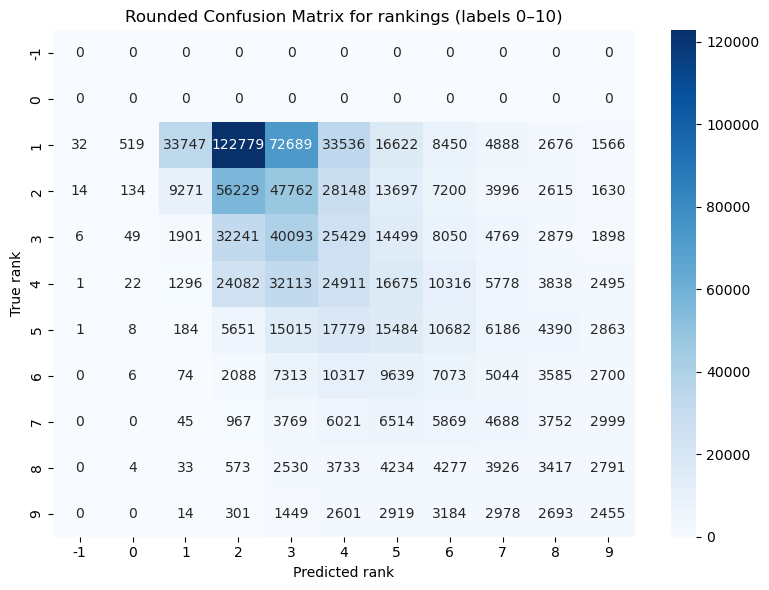

In [48]:
# 1) Round and clamp values to [0, 10]
true_rounded = np.round(y_test.flatten()).astype(int)
pred_rounded = np.round(y_pred.flatten()).astype(int)

# 2) Explicitly define labels 0–10
labels = list(range(min(pred_rounded), 10))

# 3) Compute confusion matrix for these classes only
cm = confusion_matrix(true_rounded, pred_rounded, labels=labels)

# 4) Plot with correct tick labels
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted rank")
plt.ylabel("True rank")
plt.title("Rounded Confusion Matrix for rankings (labels 0–10)")
plt.tight_layout()
plt.savefig("graphs/48_multi_confusion_matrix.png") 
plt.show()


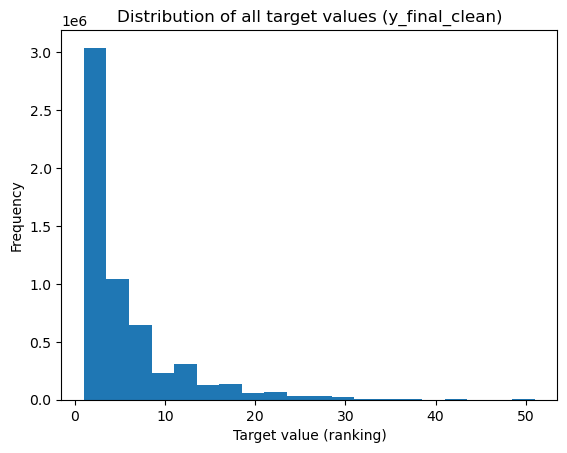

In [23]:
# Plot a histogram of all target values (flattened) to visualize their distribution
plt.hist(y_final_clean.flatten(), bins=20)
plt.title("Distribution of all target values (y_final_clean)")
plt.xlabel("Target value (ranking)")
plt.ylabel("Frequency")
plt.savefig("graphs/48_multi_hist_y_final_clean.png") 
plt.show()

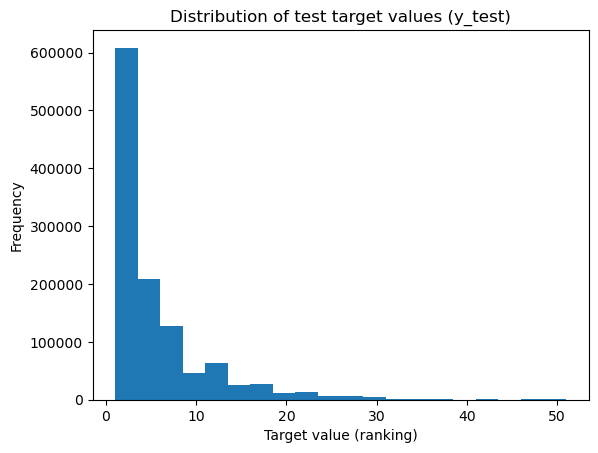

In [24]:
# Plot a histogram of the test target values to visualize their distribution
plt.clf()  # clear figure
plt.hist(y_test.flatten(), bins=20)
plt.title("Distribution of test target values (y_test)")
plt.xlabel("Target value (ranking)")
plt.ylabel("Frequency")
plt.savefig("graphs/48_multi_hist_y_test_clean.png")
plt.show()

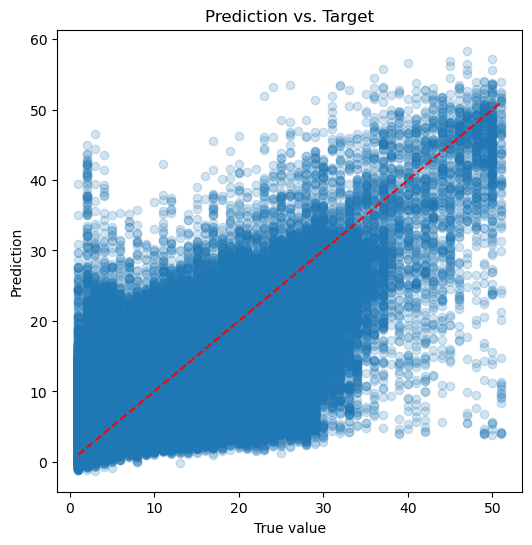

In [25]:
# Scatter plot: true values vs. predicted values to visualize prediction quality
plt.figure(figsize=(6,6))
plt.scatter(y_test.flatten(), y_pred.flatten(), alpha=0.2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal diagonal line
plt.xlabel("True value")
plt.ylabel("Prediction")
plt.title("Prediction vs. Target")
plt.savefig("graphs/48_multi_scatter_plot.png") 
plt.show()

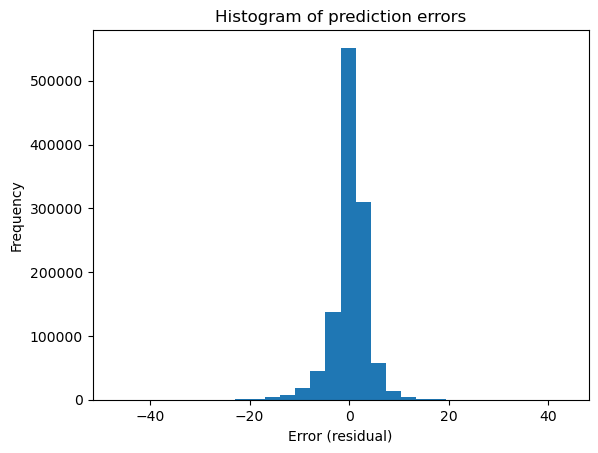

In [26]:
# Calculate and plot the histogram of prediction errors (residuals)
errors = y_pred.flatten() - y_test.flatten()
plt.hist(errors, bins=30)
plt.xlabel("Error (residual)")
plt.ylabel("Frequency")
plt.title("Histogram of prediction errors")
plt.savefig("graphs/48_multi_prediction_errors.png") 
plt.show()

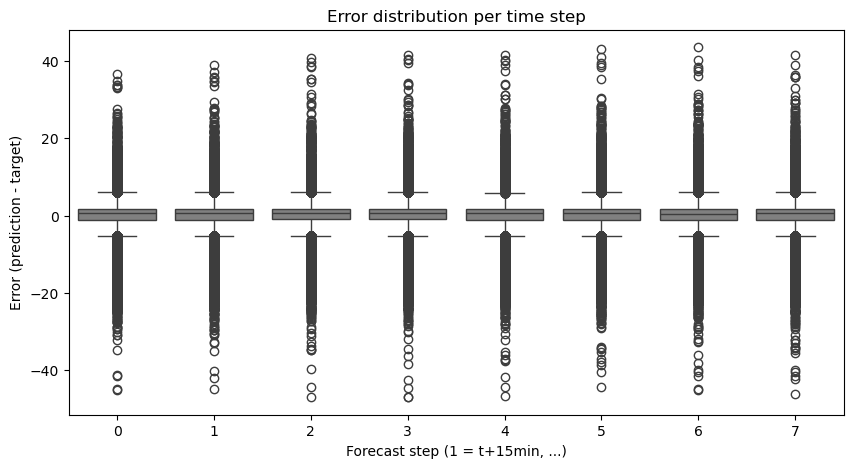

In [27]:
# Plot the error (prediction minus target) distribution for each forecast step using boxplots
errors_per_step = y_pred - y_test

# Plot
plt.figure(figsize=(10, 5))
sns.boxplot(data=errors_per_step, color='gray')  # <-- einheitliche Farbe hier
plt.xlabel("Forecast step (1 = t+15min, ...)")
plt.ylabel("Error (prediction - target)")
plt.title("Error distribution per time step")
plt.savefig("graphs/48_multi_error_per_timestep.png")
plt.show()

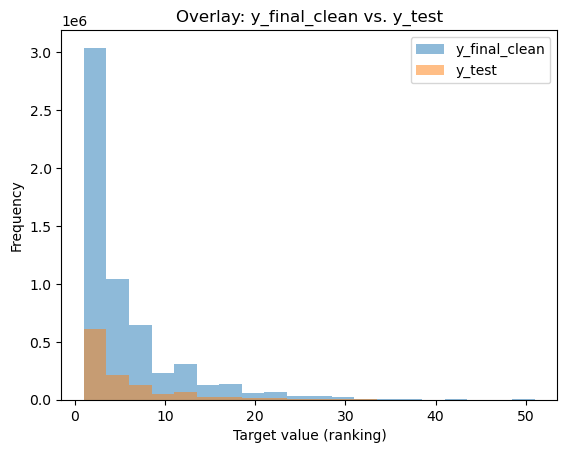

In [28]:
# Test for overlay between y_final_clean and y_test

plt.hist(y_final_clean.flatten(), bins=20, alpha=0.5, label='y_final_clean')
plt.hist(y_test.flatten(), bins=20, alpha=0.5, label='y_test')
plt.title("Overlay: y_final_clean vs. y_test")
plt.xlabel("Target value (ranking)")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("graphs/48_multi_overlay.png")
plt.show()

In [29]:
# Minimum and maximum values in y_test (true targets)
print("Min/Max y_test:", np.nanmin(y_test), np.nanmax(y_test))

# Minimum and maximum values in y_pred (model predictions)
print("Min/Max y_pred:", np.nanmin(y_pred), np.nanmax(y_pred))

# Unique integer values in the rounded true targets
print("Unique rounded values in y_test:", np.unique(true_rounded))

# Unique integer values in the rounded predictions
print("Unique rounded values in y_pred:", np.unique(pred_rounded))

# Number of NaN values in y_test
print("Number of NaN in y_test:", np.isnan(y_test).sum())

# Number of NaN values in y_pred
print("Number of NaN in y_pred:", np.isnan(y_pred).sum())

Min/Max y_test: 1.0 51.0
Min/Max y_pred: -1.2572064 58.347145
Unique rounded values in y_test: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51]
Unique rounded values in y_pred: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58]
Number of NaN in y_test: 0
Number of NaN in y_pred: 0


In [57]:
# Create Table for Latex
# Example: y_test and y_pred are numpy arrays of shape (n_samples, 8)
# y_test = ...
# y_pred = ...

latex_rows = []

for step in range(y_test.shape[1]):  # 0...7
    y_true = y_test[:, step]
    y_pred_step = y_pred[:, step]

    mae = mean_absolute_error(y_true, y_pred_step)
    mse = mean_squared_error(y_true, y_pred_step)
    rmse = np.sqrt(mse)  # manually calculated

    time_step = f"t + {(step + 1) * 15}\,min"
    latex_row = f"{time_step} & {mae:.3f} & {rmse:.3f}  \\\\"
    latex_rows.append(latex_row)

# Assemble LaTeX table with evenly distributed column widths
latex_table = r"""\begin{table}[ht]
\centering
\caption{Evaluation Metrics per Forecast Horizon}
\label{tab:evaluation_metrics}
\begin{tabularx}{\textwidth}{X X X X X}
\toprule
\textbf{Time Step} & \textbf{MAE} & \textbf{RMSE} \\
\midrule
""" + "\n".join(latex_rows) + r"""
\bottomrule
\end{tabularx}
\end{table}
"""

print(latex_table)

\begin{table}[ht]
\centering
\caption{Evaluation Metrics per Forecast Horizon}
\label{tab:evaluation_metrics}
\begin{tabularx}{\textwidth}{X X X X X}
\toprule
\textbf{Time Step} & \textbf{MAE} & \textbf{RMSE} \\
\midrule
t + 15\,min & 2.322 & 3.482  \\
t + 30\,min & 2.305 & 3.456  \\
t + 45\,min & 2.313 & 3.460  \\
t + 60\,min & 2.304 & 3.453  \\
t + 75\,min & 2.306 & 3.466  \\
t + 90\,min & 2.310 & 3.468  \\
t + 105\,min & 2.317 & 3.479  \\
t + 120\,min & 2.333 & 3.508  \\
\bottomrule
\end{tabularx}
\end{table}

